### 네이버 쇼핑 키워드 인사이트

- 스마트 스토어를 운영한다고 생각하고 경쟁력이 낮으면서 많은 수익을 낼수 있는 키워드와 상품 찾기

#### 참고 서비스
- 신사임당 유투브 : https://youtu.be/Z0hL9khbpIw
- 응용 서비스 : https://whereispost.com/keyword, https://itemscout.io

#### 데이터 수집 프로세스
1. 네이버 검색광고 회원가입 및 로그인 : https://searchad.naver.com
2. 광고 시스템 > 도구 > API 사용관리
3. CUSTOMER_ID, API_KEY, SECRET_KEY 획득
4. 네이버 검색 광고 API 매뉴얼 사이트 참고 : http://naver.github.io/searchad-apidoc/#/guides
5. github 페이지 참고
    - https://github.com/naver/searchad-apidoc
    - https://github.com/naver/searchad-apidoc/blob/master/python-sample/examples/ad_management_sample.py
6. 키워드 입력하면 해당 키워드에 대한 데이터 수집
7. 추가적인 데이터 수집
    - 유튜브 크롤링
    - 네이버 1위 상품 리뷰 크롤링

- hint
    - github 페이지의 코드에서 signaturehelper.py 파일을 이용하여 header를 만들어야 합니다.

In [ ]:
!pip install konlpy
!pip install nltk
!pip install wordcloud

In [ ]:
!pip install google-api-python-client

In [ ]:
import requests, json, time
import pandas as pd
import numpy as np
import signaturehelper
import warnings
warnings.filterwarnings('ignore')

import time
import random
import requests

from bs4 import BeautifulSoup

import json

import konlpy
from konlpy.tag import *
from nltk import Text
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import count
import re


#### 1. 개별과제 : 키워드에 대한 검색량 데이터 수집

In [ ]:
def get_header(method, uri, api_key, secret_key, customer_id):
    timestamp = str(round(time.time() * 1000))
    signature = signaturehelper.Signature.generate(timestamp, method, uri, SECRET_KEY)
    return {'Content-Type': 'application/json; charset=UTF-8', 'X-Timestamp': timestamp, 'X-API-KEY': API_KEY, 'X-Customer': str(CUSTOMER_ID), 'X-Signature': signature}

In [ ]:

BASE_URL = 'https://api.naver.com'
API_KEY = ''
SECRET_KEY = ''
CUSTOMER_ID = ''

In [ ]:
def keyword_master(keyword):
    uri = '/keywordstool' # 키워드에 대한 정보를 가져올 수 있는 uri 입력
    method = 'GET'  # get   방식
    r = requests.get(BASE_URL + uri+'?hintKeywords={}&showDetail=1'.format(keyword),
                 headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))
    return pd.DataFrame(r.json()['keywordList']) # 필요한 정보만 가져와서 return
    

In [ ]:
keyword = "텀블러"
df = keyword_master(keyword)

In [ ]:
df.head()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,monthlyAvePcClkCnt,monthlyAveMobileClkCnt,monthlyAvePcCtr,monthlyAveMobileCtr,plAvgDepth,compIdx
0,텀블러,29500,157700,53.2,1275.3,0.20,0.87,15,높음
1,에르메스접시,1200,13700,3.4,123.0,0.32,0.93,13,중간
2,등산용품,2700,10800,27.8,252.6,1.15,2.45,15,높음
3,오니지,600,2020,7.7,107.3,1.44,5.72,15,높음
4,까사무띠,1320,8430,15.3,270.4,1.29,3.42,15,높음


#### 2. 개별과제 : 검색어에 대한 상품등록수 수집
- item_count : 등록된 상품수
- total_search_count : PC, Mobile 을 합친 검색량

In [ ]:
 # 키워드의 수가 너무 많아 100개만 진행하였습니다.

In [ ]:
# sum 계산을 위해 숫자가 아닌 수를 1로 변경하였습니다.
df["monthlyPcQcCnt"]= df["monthlyPcQcCnt"].replace("< 10","1")
df["monthlyMobileQcCnt"]= df["monthlyMobileQcCnt"].replace("< 10","1")

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
def item_count(keyword):
    item_count = None
    url = f"https://search.shopping.naver.com/search/all?query={keyword}&cat_id=&frm=NVSHATC"
    response = requests.get(url)
    dom = BeautifulSoup(response.text,'html.parser')
    if dom.select_one(".subFilter_num__2x0jq") is not None:
        item_count = int(dom.select_one(".subFilter_num__2x0jq").text.replace(",",""))
    return item_count

In [ ]:
df["item_count"] = df["relKeyword"].apply(item_count) # 함수 적용하여 새로운 컬럼 생성

In [ ]:
result_df= df[["relKeyword","monthlyPcQcCnt","monthlyMobileQcCnt","item_count"]] # 필요한 컬럼만 가져왔습니다.

In [ ]:
# total_search_count 계산
result_df["total_search_count"] = result_df["monthlyPcQcCnt"].astype(float) + result_df["monthlyMobileQcCnt"].astype(float)

In [ ]:
result_df.head()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count
0,텀블러,29500,157700,2546160.0,187200.0
1,에르메스접시,1200,13700,2815.0,14900.0
2,등산용품,2700,10800,1173561.0,13500.0
3,오니지,600,2020,29157.0,2620.0
4,까사무띠,1320,8430,53090.0,9750.0


In [ ]:
result_df

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count
0,텀블러,29500,157700,2546160.0,187200.0
1,에르메스접시,1200,13700,2815.0,14900.0
2,등산용품,2700,10800,1173561.0,13500.0
3,오니지,600,2020,29157.0,2620.0
4,까사무띠,1320,8430,53090.0,9750.0
...,...,...,...,...,...
1064,청소도구수납장,10,40,5094.0,50.0
1065,클리닝카트,10,10,3026.0,20.0
1066,등산용랜턴,50,240,30295.0,290.0
1067,수입유리잔,1,60,25918.0,61.0


#### 3. 개별과제 : 경쟁률
- 아이템수/검색수 : 높을수록 경쟁이 심한 상품 키워드
- 수집된 데이터에서 추가로 얻을수 있는 인사이트 추가
    - 논리적인 인사이트이면 인사이트 수준에 대한 평가는 하지 않음

In [ ]:
# competition_rate 계산
result_df["competition_rate"] =result_df["item_count"] / result_df["total_search_count"]

In [ ]:
result_df

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count,competition_rate
0,텀블러,29500,157700,2546160.0,187200.0,13.601282
1,에르메스접시,1200,13700,2815.0,14900.0,0.188926
2,등산용품,2700,10800,1173561.0,13500.0,86.930444
3,오니지,600,2020,29157.0,2620.0,11.128626
4,까사무띠,1320,8430,53090.0,9750.0,5.445128
...,...,...,...,...,...,...
1064,청소도구수납장,10,40,5094.0,50.0,101.880000
1065,클리닝카트,10,10,3026.0,20.0,151.300000
1066,등산용랜턴,50,240,30295.0,290.0,104.465517
1067,수입유리잔,1,60,25918.0,61.0,424.885246


In [ ]:
final = result_df.sort_values(by='competition_rate', ascending=True).head(30)

In [ ]:
print("추천 하는 5개의 키워드 \n",final["relKeyword"][:5],"입니다")

추천 하는 5개의 키워드 
 35     에르메스가든파티30
741        오덴세머그컵
41         에르메스반지
622        커피빈텀블러
290       블루보틀텀블러
Name: relKeyword, dtype: object 입니다


### 키워드에서 가장 많은 명사 찾기

In [ ]:
text = "".join(result_df["relKeyword"].values)
len(text)

6030

In [ ]:
okt = Okt()
nouns = okt.nouns(text)

In [ ]:
review = Text(nouns,name = "review")
datas = review.vocab()

In [ ]:
wc = WordCloud(font_path = "D2Coding.ttf",background_color = "white")

In [ ]:
stop_words = ["텀블러"]
words = dict(datas)

for stop_word in stop_words :
  del words[stop_word]

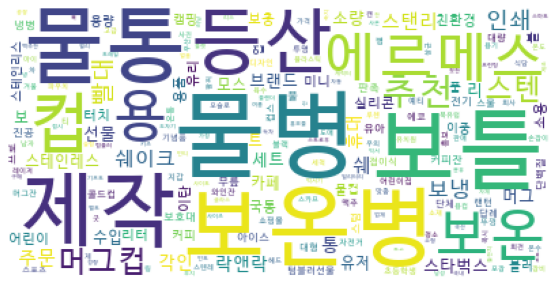

In [ ]:
plt.figure(figsize = (20,5))
plt.imshow(wc.generate_from_frequencies(words))
plt.axis('off')
plt.show()

분석 결과 , 경쟁률 낮은 브랜드 상품의 이름을 키워드로 사용하는 것이 유리하다는 결론이 나왔다. 또한 경쟁률이 높은 키워드를 WordClouding해 본 결과, “보온”이 제품의 구매에 큰 요소로 작용하고 있으므로 이를 홍보에 사용하는 것이 효과적이라고 생각한다.

### 추가적인 데이터 수집 -  유튜브 동영상 크롤링
- 크롤링 방법 : 유튜브 Api 사용
- 크롤링 이유유 : 경쟁력을 가지는 키워드 중에 동영상이 포함되었기 때문에 많은 사람들이 이용하는 동영상 플랫폼에서 “실내자전거”를 검색하고 제품을 검색하러 오는 경우가 많을 것으로 예상된다. 따라서 유튜브 동영상 정보를 가져와 합리적인 키워드를 도출할 수 있다고 생각되었다

In [ ]:
from apiclient.discovery import build

In [ ]:
YOUTUBE_API_KEY = ''

In [ ]:
youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)

In [ ]:
# api를 통해 검색하여 가져오기
search_response = youtube.search().list(
    part='snippet',
    q='텀블러',
    maxResults = 50,
    type='video',
).execute()

In [ ]:
# 원하는 정보 가져와 데이터 프레임화
youtube = []
for response in search_response['items']:
    video_names = response['snippet']['title']
    video_tag = response['snippet']["description"]
    youtube.append({"video_names":video_names,
                   "video_tag":video_tag})

In [ ]:
df =pd.DataFrame(youtube)

In [ ]:
df.head(50)

,video_names,video_tag
0,어떤컵 사용하시나요!! 텀블러 이제는 알고 구입하세요-진공컵과 이중컵에 차이,안녕하십니까 쿠자입니다. 텀블러 많이 사용하시나요? 텀블러도 다 같은 텀블러가 아니...
1,드디어 찾은 인생 텀블러!!+생활꿀템 추천/오드라이프 잡화점 7월🍒,오드라이프잡화점 #텀블러 추천 안녕하세요:) 어김없이 돌아온 오드라이프 잡화점 7월...
2,"[팩트체크] 스테인리스 텀블러, 매일 사용하면 &#39;납 중독&#39;?",안쪽 재질이 스테인리스스틸로 된 텀블러를 오래 쓰면 납 중독 된다. 6개월 쓰면 바...
3,"스탠리 텀블러, 이 영상 하나로 끝! ( 영혼을 갈아넣은 리뷰 )","스탠리 텀블러, 머그, 보틀, 보온병 ~ 어떤 걸 구매할지 고민이라면 이 영상을 클..."
4,🔥삶의 질 상승템 운동 ver.🔥 (마스크/텀블러/레깅스/프로틴/장비빨/바쁜현대인템...,Business contact : min_seon1215@naver.com FOLL...
5,스타벅스 텀블러 추천템&amp;비추천템☕️ | 구매 꿀팁까지!💖,안녕하세요 감자별입니다 ⭐ 오늘은 제가 몇 년동안 야금야금 모았던 스타벅스 텀블러...
6,매일 사용하는 스테인리스 텀블러 납중독?(6개월마다 바꿔야 하나요?) 발암물질 피하...,"4분 25초 자막 오류 : ""식초와 베이킹소다"" 를 ""베이킹소다"" 로 수정합니다. ..."
7,10년차 텀블러 덕후가 추천하는 라이프스타일별 Top4 텀블러☕️,영상 속 나온 제품 정보가 궁금하시다면 링크를 클릭해주세요. 01 - 모슈 보온보냉...
8,2022 스타벅스 봄md 전제품 리뷰 가격안내 언박싱/2022 스타벅스 벚꽃md/2...,2022스타벅스봄md #스타벅스봄md #스타벅스md 2022 스타벅스 봄 MD 전제...
9,"스테인레스 텀블러 세척, 연마제 제거 방법","스테인레스 새 텀블러나 보온병, 냄비등을 구입하고 나서 바로 해야할 일들입니다. -..."


### 인사이트
- 가장 경쟁률이 높은 것은 싸이클 가격이다. 따라서 실내 자전거의 제품의 경쟁력을 높이기 위해서는 싸이클 가격을 합리적으로 제안하는 것이 좋다
- 두번째로 많이 검색된 실내자전거동영상이다. 따라서 실내 자전거의 제품을 올릴 때 제품을 설명하는 동영상을 같이 올리면 경쟁력을 높일 수 있다.
- 마지막으로 키워드의 명사 수를 count해본 결과, 제품의 특성상 앉는 부분인 엉덩이의 편암함, 허벅지 ,하체에 얼마나 효과적인지를 제품 설명에 추가하는 것이 합리적으로 보입니다.
- 자전거 동영상의 키워드를 많이 검색한 것으로 보아, 가장 많은 동영상 시청 플랫폼인 유튜브와 연결되어 합리적인 키워드를 뽑아낼 수 있지 않을까 생각하였습니다. 그래서 이를 유튜브 동페영상을 통해 크롤링해본 결과, 실내에서 하는 활동이기 때문에 소음, 유산소 운동, 효과적인 체지방 분해 등이 많이 검색 되었다는 것을 확인할 수 있었습니다. 이를 통해 사람들이 실내자전거 제품을 구매할 때 어떤 키워드의 동영상을 검색하는가?를 크롤링 해본 결과, 실내 자전거 특성상 소음을 적게, 그리고 효과적으로 유산소 운동을 할 수 있는 방법등의 유튜브 동영상이 많이 있다는 것을 확인할 수 있었고 이러한 소비자의 필요한 부분을 제품의 설명에 추가하여 더 많은 경쟁력을 얻을 수 있다고 생각합니다.


### 추가적인 데이터 수집 - 1위 상품 벤치마킹

In [ ]:
def get_request_url(url):
    try :
        req = requests.get(url)
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')
        print("URL request Success")
        return soup

    except Exception as e:
        print("Error for URL")
        return None

In [ ]:
element = get_request_url("https://search.shopping.naver.com/catalog/19450308684?query=텀블러&NaPm=ct=l01zsfc8|ci=83f336535081ab5ec93e4b5499b03c3abf188a50|tr=slsl|sn=95694|hk=8c40fba7dc1ebb6eaca0447ffb3d4db932412137")

In [ ]:
reviews = element.select("#section_review > ul ") #> li.reviewItems_expand__3Gk1h > div.reviewItems_etc_area__2P8i3 > span:nth-child(4)

In [ ]:
reviews = reviews[0].select("li")

In [ ]:
review_list = []
for review in reviews:
  review_list.append({'content':review.select_one(".reviewItems_text__XIsTc").text})

review_df = pd.DataFrame(review_list)

In [ ]:
text = "".join(review_df["content"].values)
len(text)

In [ ]:
okt = Okt()
nouns = okt.nouns(text)

In [ ]:
review = Text(nouns,name = "review")
datas = review.vocab()

In [ ]:
wc = WordCloud(font_path = "D2Coding.ttf",background_color = "white")

In [ ]:
plt.figure(figsize = (20,5))
plt.imshow(wc.generate_from_frequencies(datas))
plt.axis('off')
plt.show()

In [ ]:
from nltk.classify import NaiveBayesClassifier

In [ ]:
df_dic = pd.read_csv("/content/subjectivity-polarity.csv", encoding='utf-8')
df = df_dic[df_dic['max.value'].notnull()]
df = df[['ngram','max.value']]

p = r'^[가-힣]+'

pos_dic = []
neg_dic = []
neu_dic = []

In [ ]:

for i, row in df.iterrows():
    if row['max.value'] ==  'POS':
        pos_dic.extend(re.findall(p, row['ngram']))
    elif row['max.value'] ==  'NEG':
        neg_dic.extend(re.findall(p, row['ngram']))
    elif row['max.value'] ==  'NEUT':
        neu_dic.extend(re.findall(p, row['ngram']))

# 중복 단어를 제거하기 위해서 set로 만들었다가 list로 변환시킨다
positive_vocab = list(set(pos_dic))
negative_vocab = list(set(neg_dic)) 
neutral_vocab = list(set(neu_dic)) 

def word_feats(words):
    return dict((word, True) for word in words)

# 사전의 긍정, 부정, 중립단어를 navie bayes에 학습시킬 준비를 한다
positive_features = [(word_feats(pos), 'pos') for pos in positive_vocab]
negative_features = [(word_feats(neg), 'neg') for neg in negative_vocab]
neutral_features = [(word_feats(neu), 'neu') for neu in neutral_vocab]

# 트레인 데이터셋 생성 완료! naive bayes에 학습 시킨다
train_set = negative_features + positive_features + neutral_features
classifier = NaiveBayesClassifier.train(train_set)

# 예측하기 위해 데이터셋 준비(_data.csv 앞에 글자만 작성. beauty를 예시로 써둠)

print('총 문장수는 '+ str(len(datas)) + '개 입니다')

neg = 0; pos = 0 ;neu = 0;
pos_word = ['POS'] ; neg_word = ['NEG'] ;neu_word = ['NEU'];

# for문으로 예측하고 싶은 문장을 돌려서 한 문장씩 예측 시킨다
for sentence in review_df['content']:
    sentence = sentence.lower()
    words = sentence.split(',')

    for word in words:
        classResult = classifier.classify(word_feats(word))
        if classResult == 'neg':
            neg = neg + 1
            neg_word.append(word)
        elif classResult == 'pos':
            pos = pos + 1
            pos_word.append(word)
        elif classResult == 'neu' :
            neu = neu +1
            neu_word.append(word)

# 결과 출력시키기
print('긍정의 문장 수는 ' + str(pos) +'개 입니다')
print('부정의 문장 수는 ' + str(neg) +'개 입니다')
print('중립의 문장 수는 ' + str(neu) +'개 입니다')




 벤치 마킹 상품의 리뷰를 분석해본 결과, 부정적인 문장을 가지는 댓글이 없었다. ​

- 이를 통해 벤치 마킹 상품이 매우 긍정적인 평가를 받고 있는 것을 확인할 수 있었다.​

- 또한 , 리뷰에 포함된 단어들을 Word Clouding을 통해 시각화해본 결과, 민트 ,블랙에 대한 언급이 많았다. 즉 소비자들은 텀블러의 외형을 소비의 주요한 요소로 보고 있다는 것을 확인할 수 있다. 또한 밀폐, 뚜껑을 통해 제품이 얼마나 밀폐되어 보관되는 지도 중요한 요소로 작용하고 있다는 것을 확인할 수 있다.​

​

따라서 이를 토대로 "텀블러"를 판매할 경우 제품의 외형, 밀폐 정도,보온을 강조하여 판매하면 경쟁력을 가질 것으로 보고있다.